In [ ]:
!pip install torch torchvision matplotlib

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Epoch [1/10] Loss: 164.3748
Epoch [2/10] Loss: 121.2820
Epoch [3/10] Loss: 114.5211
Epoch [4/10] Loss: 111.6053
Epoch [5/10] Loss: 109.8342
Epoch [6/10] Loss: 108.6767
Epoch [7/10] Loss: 107.8205
Epoch [8/10] Loss: 107.1637
Epoch [9/10] Loss: 106.6910
Epoch [10/10] Loss: 106.2222


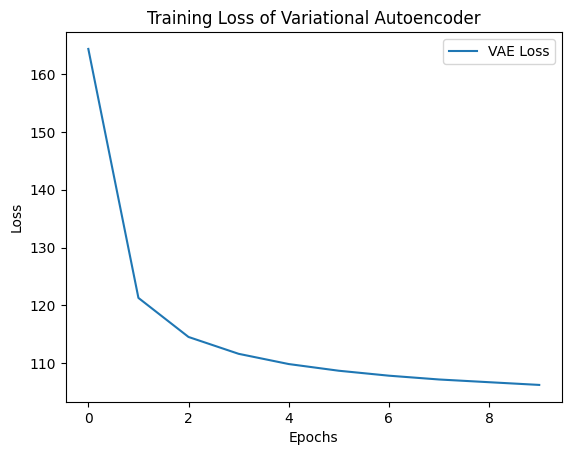

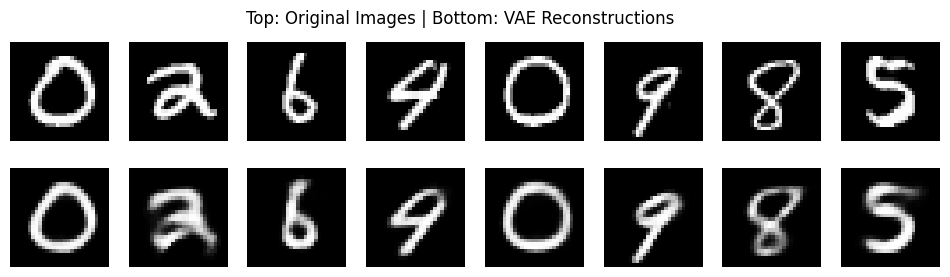

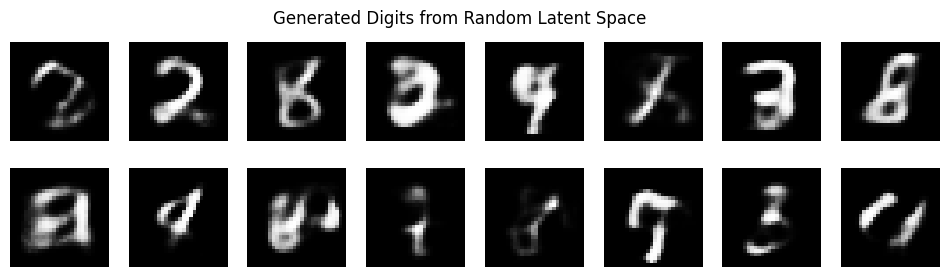

In [ ]:
# vae_mnist.py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ---- Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load MNIST dataset
tf = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='data', train=True, transform=tf, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# ---- Variational Autoencoder
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, 20)     # Mean of latent vector
        self.fc_logvar = nn.Linear(400, 20) # Log variance of latent vector
        self.fc2 = nn.Linear(20, 400)
        self.fc3 = nn.Linear(400, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # z = μ + σ * ε

    def decode(self, z):
        h2 = self.relu(self.fc2(z))
        return self.sigmoid(self.fc3(h2))

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ---- Loss Function (Reconstruction + KL Divergence)
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # KL Divergence: how latent distribution differs from standard normal
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# ---- Model, Optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---- Training
epochs = 10
train_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch}/{epochs}] Loss: {avg_loss:.4f}")

# ---- Plot Training Loss
plt.plot(train_losses, label="VAE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss of Variational Autoencoder")
plt.legend()
plt.show()

# ---- Reconstruction Visualization
model.eval()
imgs, _ = next(iter(train_loader))
imgs = imgs[:8].to(device)
with torch.no_grad():
    recons, _, _ = model(imgs)

imgs, recons = imgs.cpu(), recons.view(-1, 1, 28, 28).cpu()

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(imgs[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recons[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle("Top: Original Images | Bottom: VAE Reconstructions")
plt.show()

# ---- Sample new images from random latent space
with torch.no_grad():
    z = torch.randn(16, 20).to(device)
    samples = model.decode(z).view(-1, 1, 28, 28).cpu()
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(16):
        axes[i//8, i%8].imshow(samples[i].squeeze(), cmap='gray')
        axes[i//8, i%8].axis('off')
plt.suptitle("Generated Digits from Random Latent Space")
plt.show()
